In [21]:
import pandas as  pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

import matplotlib.pyplot as plt
import graphviz
import os

os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'
plt.style.use('bmh')

#from stop_words import get_stop_words
#nltk.download('stopwords')


### <span style="color:#006400">**0. Adição de novas palavras ao Stopwords** </span>

In [22]:
import nltk
from nltk.corpus import stopwords
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')

stopwords_nltk.append('afim')
stopwords_nltk.append('kv')
stopwords_nltk.append('mw')
stopwords_nltk.append('apos')
stopwords_nltk.append('sao')
stopwords_nltk.append('atraves')
stopwords_nltk.append('seguintes')
stopwords_nltk.append('anos')
stopwords_nltk.append('devido')
stopwords_nltk.append('ccl')
stopwords_nltk.append('cges')
stopwords_nltk.append('la')
stopwords_nltk.append('ser')
stopwords_nltk.append('serao')
stopwords_nltk.append('sera')
stopwords_nltk.append('nao')
stopwords_nltk.append('ii')
stopwords_nltk.append('iii')


### <span style="color:#006400">**1. Diretório Mapeado (PARQUET)**</span>

In [23]:
datapath = '../../Data/Processed/dados_treinoteste.parquet'

### <span style="color:#006400">**2.Transferência Dados para DataFrame**</span>

In [24]:
dataframe = pd.read_parquet(datapath)

#### <span style="color:#B22222">**2.1 Formato do DataFrame**</span>

In [25]:
print('shape:', dataframe.shape)
print('columns:', dataframe.columns)


shape: (22717, 3)
columns: Index(['id', 'dsc_texto', 'tip_supervisao'], dtype='object')


### <span style="color:#006400">**3. Atributos de Predição**</span>

#### <span style="color:#B22222">**3.1 Distribuição**</span>

In [26]:
dataframe.tip_supervisao.value_counts()

oper    11390
prop    11327
Name: tip_supervisao, dtype: int64

#### <span style="color:#B22222">**3.2 Gráfico da Distribuição**</span>

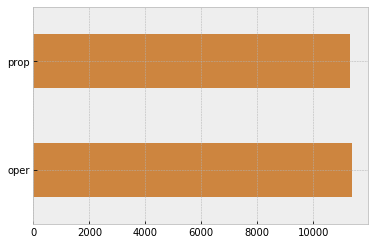

In [27]:
dataframe.tip_supervisao.value_counts().plot(kind='barh',color="#CD853F")

### <span style="color:#006400">**4. Atributo ALVO**</span>

#### <span style="color:#B22222">**4.1 CountVectorizer = Frequência de cada palavra (Em PORTUGUÊS)**</span>

In [28]:
vectorizer = CountVectorizer(dataframe.dsc_texto.values.tolist(),encoding="utf-8",
                             decode_error="strict",strip_accents=None,
                             lowercase=True, tokenizer=None,
                             stop_words= stopwords_nltk,
                             ngram_range = (1, 1),
                             min_df = 0.01,
                             max_df = 0.99,
                             analyzer="word"
                            )

text_counts = vectorizer.fit_transform(dataframe.dsc_texto.values.tolist())
text_counts

<22717x213 sparse matrix of type '<class 'numpy.int64'>'
	with 132944 stored elements in Compressed Sparse Row format>

#### <span style="color:#B22222">**4.2 Gráfico de Total de Palavras**</span>

Text(0.5, 0, '# Ocorrência das palavras')

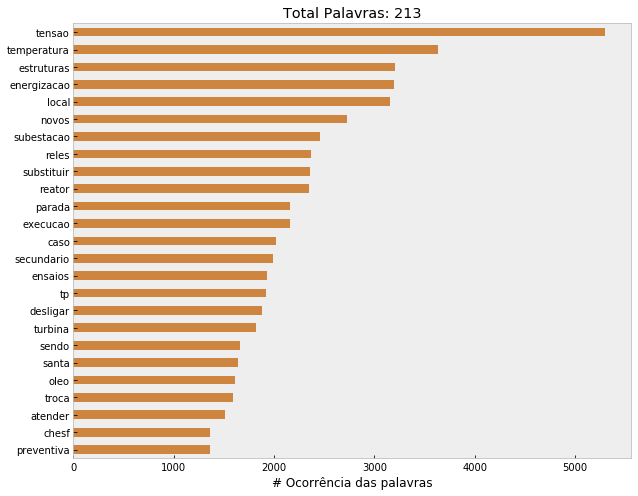

In [29]:
plt.figure(figsize=(10,8))
nshow = 25
word_count = np.asarray(text_counts.sum(axis=0))[0]

df_counts =pd.Series(word_count)
df_counts.index = list(vectorizer.vocabulary_.keys())
df_counts.sort_values().iloc[-nshow:].plot.barh(color='#CD853F')

plt.grid()
plt.title('Total Palavras: '+ str(word_count.shape[0]))
plt.xlabel('# Ocorrência das palavras')

#### <span style="color:#B22222">**4.3. Distribuição de frequências das palavras**</span>

Text(0.5, 1.0, 'Distribuição de frequencia das palavras')

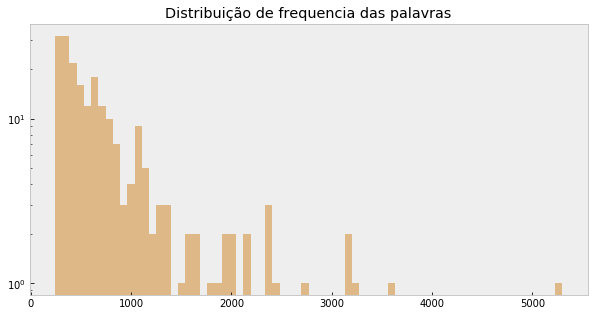

In [30]:
plt.figure(figsize=(10,5))

plt.hist(x=word_count, bins=70, color='#DEB887', orientation ='vertical')

plt.grid()
plt.yscale('log')
plt.title('Distribuição de frequencia das palavras')
#plt.xlabel('')

#### <span style="color:#B22222">**4.4. Distribuição por Atributo Predição**</span>

Text(0.5, 1.0, 'Proporção Por Atributo de Predição')

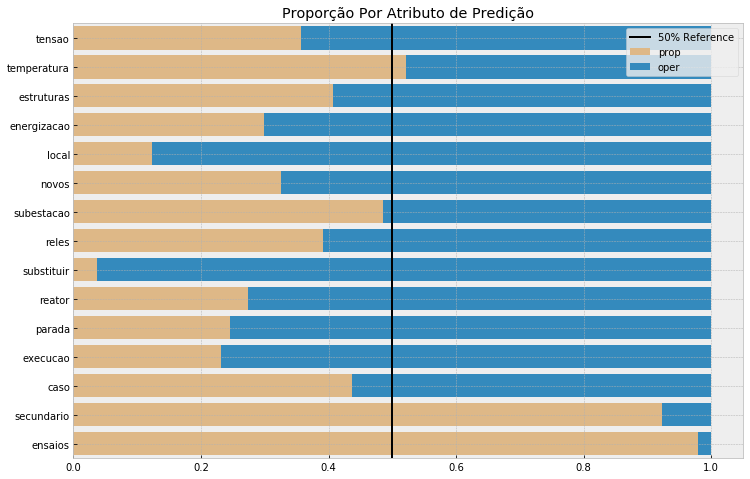

In [31]:
plt.figure(figsize=(12,8))

nshow = 15

idx = (dataframe['tip_supervisao'] == 'oper').values
word_count_neg = np.asarray(text_counts[~idx].mean(axis=0))[0]
word_count_pos = np.asarray(text_counts[ idx].mean(axis=0))[0]

idx = np.argsort(word_count)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

total_count = word_count_neg + word_count_pos

bar_neg = plt.barh(yaxis, word_count_neg[idx] / total_count[idx], label='prop', color='#DEB887')
bar_pos = plt.barh(yaxis, word_count_pos[idx] / total_count[idx],
                   left=word_count_neg[idx] / total_count[idx], label='oper')

plt.plot([0.5, 0.5],[-0.5, nshow], '-k', label='50% Reference')
plt.yticks(yaxis, vocabulary)
plt.legend()
plt.ylim((-0.5, nshow-0.5))

plt.title('Proporção Por Atributo de Predição')


### <span style="color:#006400">**5. Normalização por TF-IDF**</span>

In [32]:
vectorizer = TfidfVectorizer(dataframe.dsc_texto.values.tolist(),encoding="utf-8",
                             stop_words= stopwords_nltk,
                             ngram_range = (1, 1),lowercase=True, 
                              decode_error="strict",strip_accents=None,
                             min_df = 0.05,
                             max_df = 0.95)

text_features = vectorizer.fit_transform(dataframe.dsc_texto.values.tolist())
vocabulary = list(vectorizer.vocabulary_.keys())
text_features


<22717x25 sparse matrix of type '<class 'numpy.float64'>'
	with 43412 stored elements in Compressed Sparse Row format>

#### <span style="color:#B22222">**5.1 Distribuição Percentual** </span>

Text(0.5, 1.0, 'Distribuição Percentual TF-DF')

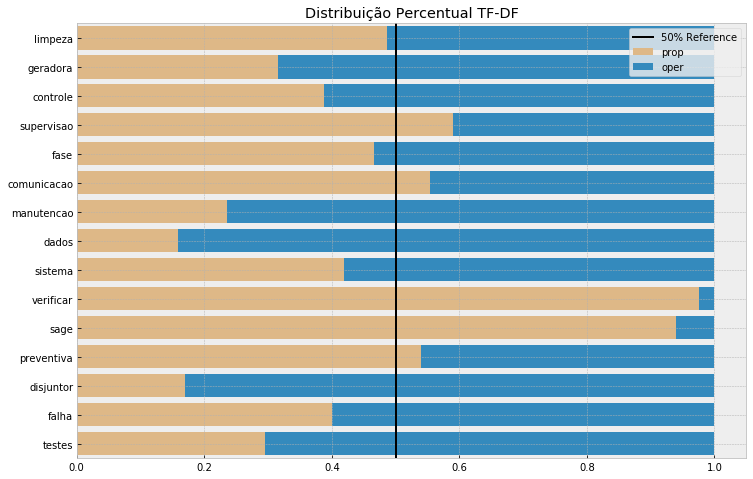

In [33]:
plt.figure(figsize=(12,8))

nshow = 15

idx = (dataframe['tip_supervisao'] == 'oper').values
word_count = np.asarray(text_features.mean(axis=0))[0]
word_count_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_count_pos = np.asarray(text_features[ idx].mean(axis=0))[0]

idx = np.argsort(word_count)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

total_count = word_count_neg + word_count_pos

bar_neg = plt.barh(yaxis, word_count_neg[idx] / total_count[idx], label='prop', color='#DEB887')
bar_pos = plt.barh(yaxis, word_count_pos[idx] / total_count[idx],
                   left=word_count_neg[idx] / total_count[idx], label='oper')

plt.plot([0.5, 0.5],[-0.5, nshow], '-k', label='50% Reference')
plt.yticks(yaxis, vocabulary)
plt.legend()
plt.ylim((-0.5, nshow-0.5))

plt.title('Distribuição Percentual TF-DF')



#### <span style="color:#B22222">**5.2 Distribuição do TF-IDF Médio** </span>

Text(0.5, 1.0, 'Distribuição do TF-IDF Médio')

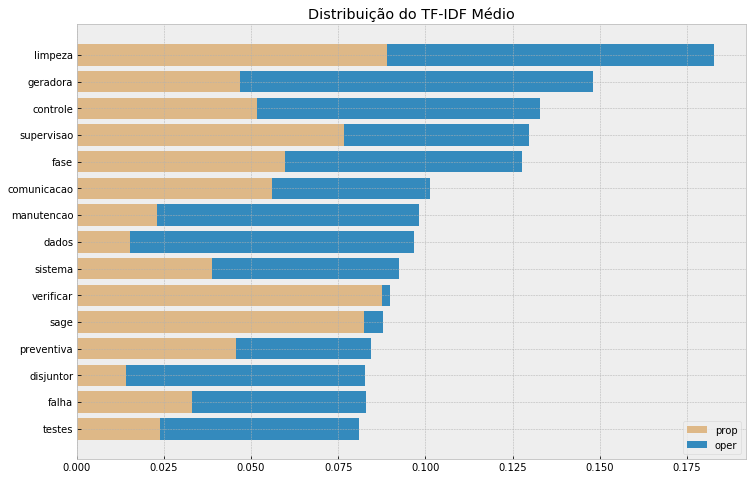

In [34]:
plt.figure(figsize=(12,8))

nshow = 15

idx = (dataframe['tip_supervisao'] == 'oper').values
word_mean     = np.asarray(text_features.mean(axis=0))[0]
word_mean_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_mean_pos = np.asarray(text_features[ idx].mean(axis=0))[0]

idx = np.argsort(word_mean)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

bar_neg = plt.barh(yaxis, word_mean_neg[idx], label='prop', color='#DEB887')
bar_pos = plt.barh(yaxis, word_mean_pos[idx], left=word_mean_neg[idx], label='oper')
plt.yticks(yaxis, vocabulary)

plt.legend()
plt.title('Distribuição do TF-IDF Médio')
#plt.xlabel('')


#### <span style="color:#B22222">**5.3 Diferença TF-IDF por Palavra** </span>

Text(0.5, 1.0, 'Diferença TF-IDF por Palavra')

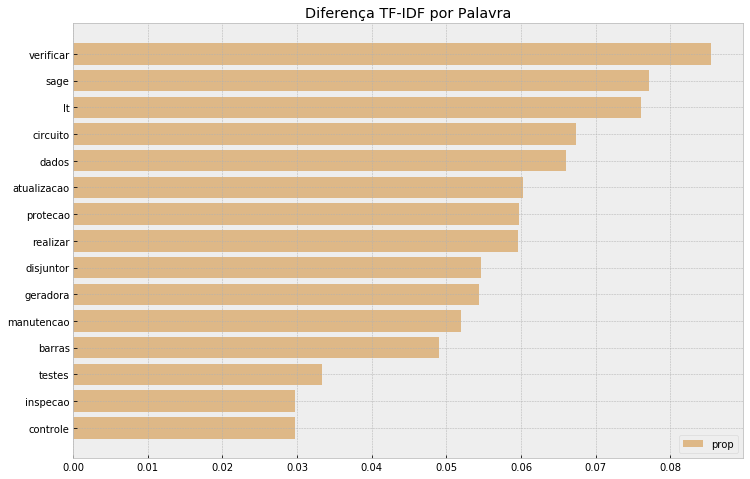

In [35]:
plt.figure(figsize=(12,8))

idx = (dataframe['tip_supervisao'] == 'oper').values
word_mean_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_mean_pos = np.asarray(text_features[ idx].mean(axis=0))[0]
word_mean_diff = np.abs(word_mean_pos - word_mean_neg)

idx = np.argsort(word_mean_diff)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

plt.barh(yaxis, word_mean_diff[idx], label='prop', color='#DEB887')
plt.yticks(yaxis, vocabulary)

plt.legend()
plt.title('Diferença TF-IDF por Palavra')
#plt.xlabel('TfIdf médio')


#### <span style="color:#B22222">**5.4 Distribuição do TfIdf Médio das Palavras**</span> 

Text(0.5, 1.0, 'Distribuição do TF-IDF médio de cada palavra')

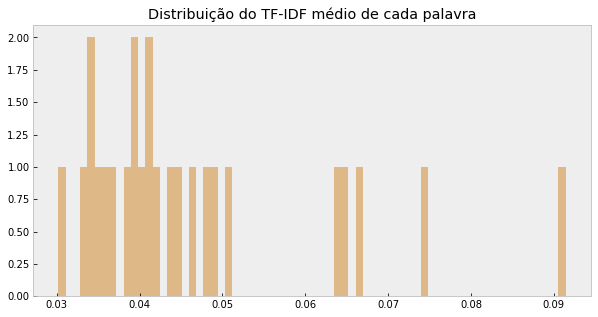

In [36]:
plt.figure(figsize=(10,5))

word_mean = np.asarray(text_features.mean(axis=0))[0]

df_tfidf = pd.Series(word_mean)
df_tfidf.index = list(vectorizer.vocabulary_.keys())

plt.hist(x=word_mean, bins=70, color='#DEB887')


plt.grid()
plt.title('Distribuição do TF-IDF médio de cada palavra')
#plt.xlabel('# TfIdf das palavras')

#### <span style="color:#B22222">**5.5 Distribuição do TF-IDF por Classe**</span> 

Text(0.5, 1.0, 'Proporção Por Classe')

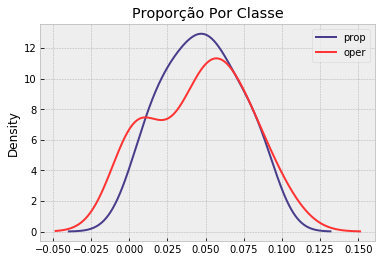

In [37]:
plt.figure(figsize=(6,4))

idx = (dataframe['tip_supervisao'] == 'oper').values
word_mean     = np.asarray(text_features.mean(axis=0))[0]
word_mean_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_mean_pos = np.asarray(text_features[ idx].mean(axis=0))[0]


df_tfidf = pd.Series(word_mean_neg)
df_tfidf.index = list(vectorizer.vocabulary_.keys()).copy()
df_tfidf.plot.kde(color='#483D8B', label='prop')

df_tfidf =pd.Series(word_mean_pos)
df_tfidf.index = list(vectorizer.vocabulary_.keys()).copy()
df_tfidf.plot.kde(color='#FF3333', label='oper')


plt.legend()
plt.title('Proporção Por Classe')
#plt.xlabel('TF-IDF médio')


### <span style="color:#006400">**6. Resultado Preliminares** </span>

In [38]:
from sklearn import tree 
from sklearn import metrics

model = tree.DecisionTreeClassifier(max_depth=10)

Y = dataframe['tip_supervisao'].values
model.fit(text_features, Y)

Ydec = model.predict(text_features)
print(metrics.classification_report(Y, Ydec))

              precision    recall  f1-score   support

        oper       0.63      0.98      0.76     11390
        prop       0.96      0.41      0.57     11327

    accuracy                           0.70     22717
   macro avg       0.79      0.70      0.67     22717
weighted avg       0.79      0.70      0.67     22717



### <span style="color:#006400">**7. Importância das Palavras** </span>

Text(0.5, 1.0, 'Importância das Palavras')

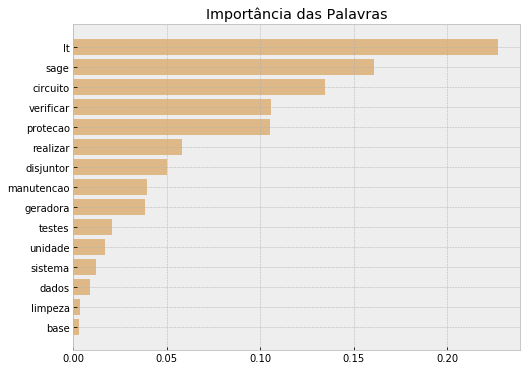

In [39]:
plt.figure(figsize=(8,6))

idx = np.argsort(model.feature_importances_)[-nshow:]
yaxis = np.arange(nshow)

plt.barh(yaxis, model.feature_importances_[idx],color='#DEB887')
plt.yticks(yaxis,np.array(list(vectorizer.vocabulary_.keys()))[idx])

plt.title('Importância das Palavras')

### <span style="color:#006400">**8. Visualização da Árvore** </span>

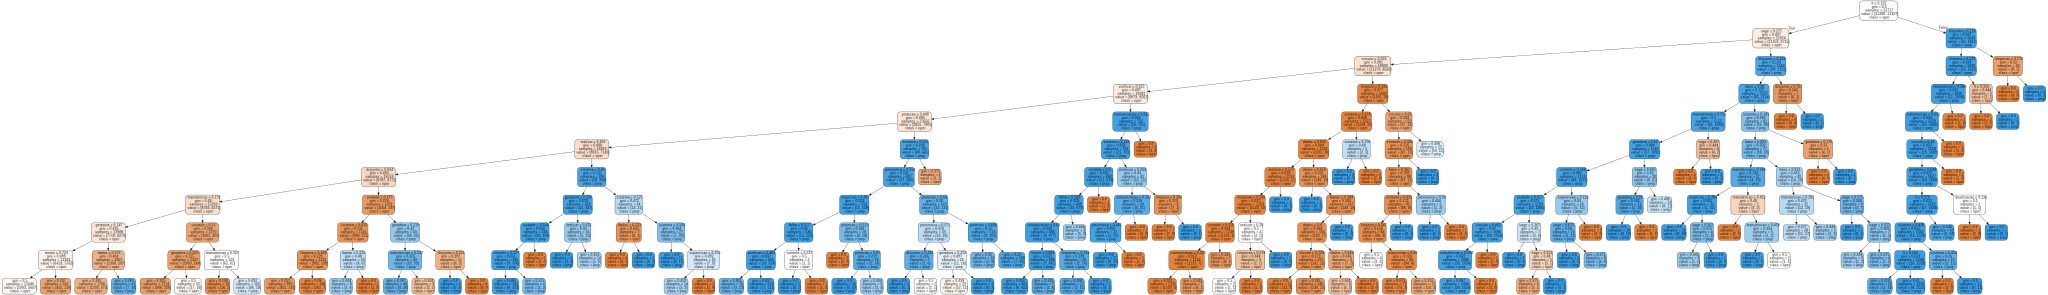

In [40]:
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=list(vectorizer.vocabulary_.keys()), 
                      class_names=model.classes_,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph